In [3]:
import tqdm as tqdm
import torch
import numpy
import pickle as pkl
from utils.head import end2end
from utils.dataset import load_compiled_data, aircraft_camera_data
from torch.utils.data import DataLoader
import torch.nn as nn
import cv2

from utils.head import *
device = torch.device('cuda:0')

In [4]:
t = 3 # Time - 5
w = 1 # Weather - 5
r = 1 # Runs - 3

data_indexes = [1,2] # Camera 1 & 2
touchdown_target_lat_lon = [1.3541354199301814, 103.97961848373048] # WSSS 02L Runway
dataset_directory = "/media/gabriel/DATA/dataset"
data_sources = [[f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/data.pkl', f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/video.avi'] for data_index in data_indexes]

# Dataset Class Initialization
acd = aircraft_camera_data(data_sources = data_sources, touchdown_target_lat_lon = touchdown_target_lat_lon)

In [5]:
n = 5200
img = acd.get_frame_from_video(n, size = (1280, 1920), batch_size = 1).cuda()

In [6]:
offset = [[19.75390625, 248.5, 9.0, 5.5], [5.056640625, 248.5, 10.109375, 4.5]]
divider = [[1895.24609375, 395.75, 175.25, 151.0],[1909.443359375, 396.5, 172.640625, 83.5]]
model = end2end('models/config/model_m_m.yaml', model_state_dict='models/head/big_dataset/kaiming_3/m_m.pt', offset = offset, divider = divider, device = device)

Input_Reg Aux DE Loaded


In [7]:
box, score, pred = model.single_infer(img)
gt = acd.get_current_dtt(n)

print(f'Error: {abs(pred - gt):.2f} nm')

Time Profile:

Object Detector    : 614.30 ms
Preprocessing      : 0.50 ms
Distance Estimator : 141.70 ms

Total Time         : 756.50 ms (1.3218724728191158 FPS)
            
Error: 0.00 nm


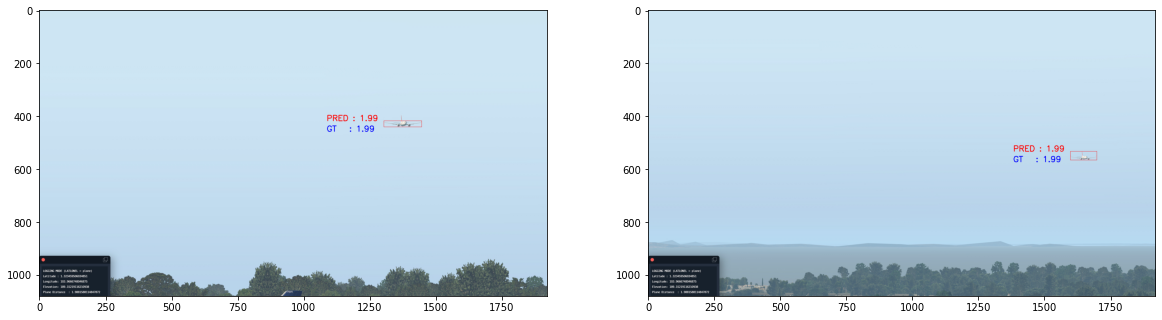

In [8]:
model.vis(img, gt, box, score, pred)